<h1 align="center">AdventureWorks Project</h1>

## Business Problem

Using a database with SQLite, gain insight by analyzing which are the best selling products and best salespeople for the outdoor sporting equipment company, AdventureWorks, and how can this insight be used to increase sales?

### SQLite Data

The data is stored in a database, which is part of a larger dataset, that includes tables Sales and Products.

#### Import Statements

In [1]:
import sqlite3, pandas as pd, matplotlib.pyplot as plt, numpy as np

#### Configurations

Autocomplete

In [2]:
%config Completer.use_jedi = False

Max Display

In [3]:
pd.set_option('display.max_colwidth', None)

#### Connect Database

In [4]:
conn = sqlite3.connect('AdventureWorks.db')

#### Table Names

In [5]:
tables_names = "select name from sqlite_master where type='table';"
df = pd.read_sql_query(tables_names, conn)
print(df)

                                     name
0                             salesperson
1                                 product
2   productmodelproductdescriptionculture
3                      productdescription
4                           productreview
5                         productcategory
6                      productsubcategory
7                        salesorderdetail
8                        salesorderheader
9                          salesterritory
10                  countryregioncurrency
11                           currencyrate


## Best Selling Products

Which are the best selling products? One approach is to use average product reviews to rank products by sales.

Approach 1

In [6]:
best_selling_by_reviews = """
select p.productId, p.name, avg(pr.rating) as avgrating, count(pr.rating) as num_rating
from product p, productReview pr
where p.productID = pr.productID
group by p.productId
order by avgrating desc;
"""
df = pd.read_sql_query(best_selling_by_reviews, conn)
print(df)

   productid                    NAME  avgrating  num_rating
0        798   Road-550-W Yellow, 40        5.0           1
1        709  Mountain Bike Socks, M        5.0           1
2        937       HL Mountain Pedal        3.0           2


#### Quick Analysis

As can be seen above, there are only a total of 4 reviews for three different products which is not a good indicator of the best selling products by average reviews. An alternative approach must be taken.

Approach 2

In [7]:
product_and_description = """
select pmdc.productModelID, pd.description
from productmodelproductdescriptionculture as pmdc
inner join
productDescription as pd
on pmdc.productDescriptionID = pd.productDescriptionID
where pmdc.cultureID = 'en'
limit 5;
"""
df = pd.read_sql_query(product_and_description, conn)
print(df)

   productmodelid  \
0               1   
1               2   
2               3   
3               4   
4               5   

                                                                                                                                                                                                                     description  
0                                                                                                                                                                      Light-weight, wind-resistant, packs to fit into a pocket.  
1                                                                                                                                                                      Traditional style with a flip-up brim; one-size fits all.  
2                                                                                                                                         Synthetic palm, flexible knuckles, breathable mesh upp

##### Using the table above as a CTE, the product name and quantity sold can now be found by joining product and salesorderdetail tables.

In [8]:
cte_joins = """
with english_description as (
    select pmdc.productModelID, pd.description
    from productmodelproductdescriptionculture as pmdc
    inner join
    productDescription as pd
    on pmdc.productDescriptionID = pd.productDescriptionID
    where pmdc.cultureID = 'en'
)
select ed.productModelID, ed.description, p.name, sum(sod.orderqty) as total_orders
from english_description ed
join
product p
on ed.productModelID = p.productModelID
join salesOrderDetail sod
on p.productID = sod.productID
group by ed.productModelID, ed.description, p.name
order by total_orders desc
limit 5;
"""
df = pd.read_sql_query(cte_joins, conn)
print(df)

   productModelID                                                description  \
0               2  Traditional style with a flip-up brim; one-size fits all.   
1             111           AWC logo water bottle - holds 30 oz; leak-proof.   
2              33   Universal fit, well-vented, lightweight , snap-on visor.   
3              11      Unisex long-sleeve AWC logo microfiber cycling jersey   
4              33   Universal fit, well-vented, lightweight , snap-on visor.   

                         NAME  total_orders  
0                AWC Logo Cap          8311  
1       Water Bottle - 30 oz.          6815  
2      Sport-100 Helmet, Blue          6743  
3  Long-Sleeve Logo Jersey, L          6592  
4     Sport-100 Helmet, Black          6532  


#### Quick Analysis

As can be seen above, a few of the most sold items include a cap, a water bottle and a helmet.

### Sales by Category

Follow up question: What is the correlation, if any, between quantity sold and price per category?

First Step - Determine total sales per product.

In [9]:
sales_by_id = """
select productID, sum(orderqty) as quantity
from salesOrderDetail
group by productID;
"""
df = pd.read_sql_query(sales_by_id, conn)
print(df)

     productid  quantity
0          707      6266
1          708      6532
2          709      1107
3          710        90
4          711      6743
..         ...       ...
261        994       378
262        996       543
263        997       656
264        998      1556
265        999      1338

[266 rows x 2 columns]


Second Step - Determine list price per category and subcategory

In [10]:
price_per_cat = """
select 
    p.productID, 
    pc.name as category, 
    ps.name as subcategory, 
    p.listprice
from product p
join
productSubcategory ps
on
p.productSubcategoryID = ps.productSubcategoryID
join productCategory pc
on
ps.productCategoryID = pc.productCategoryID;
"""
df = pd.read_sql_query(price_per_cat, conn)
print(df)

     productid     category      subcategory  listprice
0          680   Components      Road Frames    1431.50
1          706   Components      Road Frames    1431.50
2          707  Accessories          Helmets      34.99
3          708  Accessories          Helmets      34.99
4          709     Clothing            Socks       9.50
..         ...          ...              ...        ...
290        995   Components  Bottom Brackets     101.24
291        996   Components  Bottom Brackets     121.49
292        997        Bikes       Road Bikes     539.99
293        998        Bikes       Road Bikes     539.99
294        999        Bikes       Road Bikes     539.99

[295 rows x 4 columns]


Third Step - Create two CTE from both tables and join them to get the average list price and total quantity sold for each product.

In [11]:
avg_price_total_qty_sold = """
with product_quantites as (
    select productID, sum(orderqty) as quantity
    from salesOrderDetail
    group by productID
),
product_prices as (
    select 
    p.productID, 
    pc.name as category, 
    ps.name as subcategory, 
    p.listprice
from product p
join
productSubcategory ps
on
p.productSubcategoryID = ps.productSubcategoryID
join productCategory pc
on
ps.productCategoryID = pc.productCategoryID
)
select 
    pp.category, 
    pp.subcategory,
    avg(pp.listPrice) as average_price_in_subcategory,
    sum(pq.quantity) as total_items_sold_in_subcategory
from product_quantites pq
join product_prices pp
on
pq.productID = pp.productID
group by pp.category,pp.subcategory;
"""
df = pd.read_sql_query(avg_price_total_qty_sold, conn)
# print(df)

#### Quick Analysis

Plotting average_price_in_subcategory and total_items_sold_in_subcategory

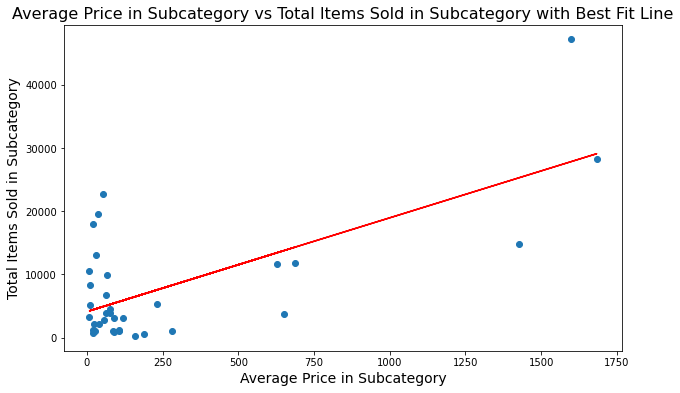

The correlation between average_price_in_subcategory and total_items_sold_in_subcategory is 0.68.


In [12]:
# Create a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df['average_price_in_subcategory'], df['total_items_sold_in_subcategory'])

# Calculate the best fit line
m, b = np.polyfit(df['average_price_in_subcategory'], df['total_items_sold_in_subcategory'], 1)

# Add the best fit line
plt.plot(df['average_price_in_subcategory'], m*df['average_price_in_subcategory'] + b, color='red')

plt.xlabel('Average Price in Subcategory', fontsize = 14)
plt.ylabel('Total Items Sold in Subcategory', fontsize = 14)
plt.title('Average Price in Subcategory vs Total Items Sold in Subcategory with Best Fit Line', fontsize=16)
plt.show()

# Calculate the correlation
correlation = df['average_price_in_subcategory'].corr(df['total_items_sold_in_subcategory'])

print(f"The correlation between average_price_in_subcategory and total_items_sold_in_subcategory is {correlation.round(2)}.")

## Top Salespeople

Who are the top salespeople and does the commission percentage motive them?

Approach 1

Top 5 Salespeople

In [13]:
# Turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

top_five = """
select businessEntityID, salesytd
from salesPerson
order by salesytd desc
limit 5;
"""
df = pd.read_sql_query(top_five, conn)
print(df)

   businessentityid   salesytd
0               276 4251368.55
1               289 4116871.23
2               275 3763178.18
3               277 3189418.37
4               290 3121616.32


In [14]:
# Reset to the default option
# pd.reset_option('display.float_format')

##### This data will be cross-referenced by use of another approach to calcuate top salespeople.

Approach 2

In [15]:
top_5_2014 = """
select salespersonid, sum(subtotal) as totalsales
from salesOrderHeader
where (salesPersonID is not null and salesPersonId <> "")
and orderDate >= '2014-01-01'
group by salespersonid
order by totalsales desc
limit 5;
"""
df = pd.read_sql_query(top_5_2014, conn)
print(df)

   salespersonid  totalsales
0            289  1382996.58
1            276  1271088.52
2            275  1057247.38
3            282  1044810.83
4            277  1040093.41


#### Quick Analysis

The second approach includes salespersonid 282 instead of salespersonid 290 from the first approach. Therefore, a third approach needs to be implemented.

Approach 3

In [16]:
total_by_id = """
select salesOrderID,
       sum((unitPrice - (unitPrice * unitPriceDiscount)) * orderQty) as ordertotal
from salesOrderDetail
group by salesOrderID
limit 10;
"""
df = pd.read_sql_query(total_by_id, conn)
print(df)

   salesorderid  ordertotal
0         43659    20565.62
1         43660     1294.25
2         43661    32726.48
3         43662    28832.53
4         43663      419.46
5         43664    24432.61
6         43665    14352.77
7         43666     5056.49
8         43667     6107.08
9         43668    35944.16


In [17]:
top_sales_2014 = """
with salesPersonAndOrders as (
    select salesPersonID, salesOrderID
    from salesOrderHeader
    where (salesPersonID is not null and salesPersonId <> "")
    and orderDate >= '2014-01-01'
), orders as (
    select salesOrderID,
        sum((unitPrice - (unitPrice * unitPriceDiscount)) * orderQty) as ordertotal
        from salesOrderDetail
        group by salesOrderID
)
select spo.salesPersonID, sum(o.ordertotal) as ordertotalsum
from salesPersonAndOrders spo
join
orders o
on
spo.salesOrderID = o.salesOrderID
group by spo.salesPersonID
order by ordertotalsum desc
limit 5;
"""
df = pd.read_sql_query(top_sales_2014, conn)
print(df)

   salesPersonID  ordertotalsum
0            289     1382996.58
1            276     1271088.52
2            275     1057247.38
3            282     1044810.83
4            277     1040093.41


#### Quick Analysis

This manual calculation of the top 5 salespersons matches the hard-coded sales data retrieved from *Approach 2* query.

### Sales by Commission

Follow up question: What is the correlation, if any, between total sales of salespeople and commission percentages?

In [18]:
sales_commission = """
with salesPersonTotalSales as (
    with salesPersonAndOrders as (
        select salesPersonID, salesOrderID
        from salesOrderHeader
        where (salesPersonID is not null and salesPersonId <> "")
        and orderDate >= '2014-01-01'
), orders as (
    select salesOrderID,
    sum((unitPrice - (unitPrice * unitPriceDiscount)) * orderQty) as ordertotal
    from salesOrderDetail
    group by salesOrderID
)
    select spo.salesPersonID, sum(o.ordertotal) as ordertotalsum
    from salesPersonAndOrders spo
    join
    orders o
    on
    spo.salesOrderID = o.salesOrderID
    group by spo.salesPersonID
)
select spts.salesPersonID, spts.ordertotalsum, sp.commissionpct
from salesPersonTotalSales spts
join
salesPerson sp
on
spts.salesPersonID = sp.businessEntityID;
"""
df = pd.read_sql_query(sales_commission, conn)
# print(df)

#### Quick Analysis

Plotting ordertotalsum and commissionpct

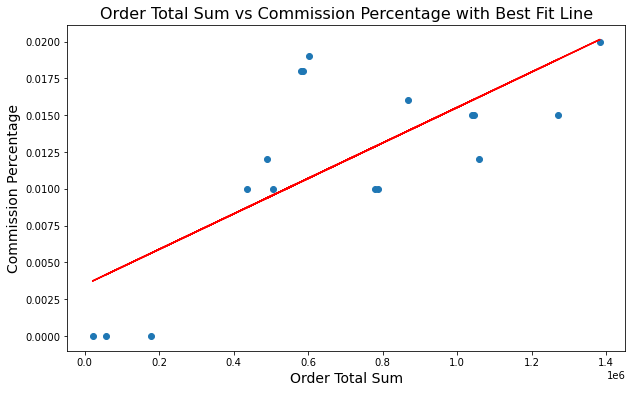

The correlation between average_price_in_subcategory and total_items_sold_in_subcategory is 0.74.


In [19]:
# Create a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df['ordertotalsum'], df['commissionpct'])

# Calculate the best fit line
m, b = np.polyfit(df['ordertotalsum'], df['commissionpct'], 1)

# Add the best fit line
plt.plot(df['ordertotalsum'], m*df['ordertotalsum'] + b, color='red')

plt.xlabel('Order Total Sum', fontsize = 14)
plt.ylabel('Commission Percentage', fontsize = 14)
plt.title('Order Total Sum vs Commission Percentage with Best Fit Line', fontsize=16)
plt.show()

# Calculate the correlation
correlation = df['ordertotalsum'].corr(df['commissionpct'])

print(f"The correlation between average_price_in_subcategory and total_items_sold_in_subcategory is {correlation.round(2)}.")

##### Since sales are recorded in various currencies, the total sales per salespeople must be converted to one currency, in this case USD, for fair analysis.

### Converting All Sales to USD for Fair Analysis

In [20]:
currency = """
select 
    soh.salesPersonID, 
    soh.salesOrderID, 
    soh.currencyRateID, 
    cr.toCurrencyCode
from salesOrderHeader soh
left join
currencyRate cr
on
soh.currencyRateID = cr.currencyRateID
where (soh.salesPersonID is not null and soh.salesPersonID <> "")
and soh.orderDate >= '2014-01-01'
order by soh.salesPersonID
limit 10;
"""
df = pd.read_sql_query(currency, conn)
print(df)

   salespersonid  salesorderid currencyrateid tocurrencycode
0            274         65294                          None
1            274         65298                          None
2            274         67277                          None
3            274         67286          11427            CAD
4            274         69528                          None
5            274         69545                          None
6            274         71779                          None
7            274         71919                          None
8            275         65205                          None
9            275         65215                          None


Replace "None" in toCurrencycode column with "USD" for clearer user understanding.

In [21]:
to_usd = """
select 
    soh.salesPersonID, 
    soh.salesOrderID,
        case
            when (cr.toCurrencyCode is null) then 'USD'
            else cr.toCurrencyCode
        end as toCurrencyCode
from salesOrderHeader soh
left join
currencyRate cr
on
soh.currencyRateID = cr.currencyRateID
where (soh.salesPersonID is not null and soh.salesPersonID <> "")
and soh.orderDate >= '2014-01-01'
order by soh.salesPersonID
limit 10;
"""
df = pd.read_sql_query(to_usd, conn)
print(df)

   salespersonid  salesorderid toCurrencyCode
0            274         65294            USD
1            274         65298            USD
2            274         67277            USD
3            274         67286            CAD
4            274         69528            USD
5            274         69545            USD
6            274         71779            USD
7            274         71919            USD
8            275         65205            USD
9            275         65215            USD


toCurrencyCode column is then included in CTE *salesPersonAndOrders* to create *salesPersonTotalSales* table which is then joined with *salesPerson* to view total sales by currency and identify the top salespeople.

In [22]:
total_sales = """ 
with salesPersonTotalSales as (
    with salesPersonAndOrders as (
        select soh.salesPersonID, soh.salesOrderID,
        case
            when (cr.toCurrencyCode is null) then 'USD'
            else cr.toCurrencyCode
        end as toCurrencyCode
        from salesOrderHeader soh
        left join
        currencyRate cr
        on
        soh.currencyRateID = cr.currencyRateID
        where (soh.salesPersonID is not null and soh.salesPersonID <> "")
        and soh.orderDate >= '2014-01-01'
), orders as (
    select salesOrderID,
    sum((unitPrice - (unitPrice * unitPriceDiscount)) * orderQty) as ordertotal
    from salesOrderDetail
    group by salesOrderID
)
    select spo.salesPersonID, spo.toCurrencyCode, sum(o.ordertotal) as ordertotalsum
    from salesPersonAndOrders spo
    join
    orders o
    on
    spo.salesOrderID = o.salesOrderID
    group by spo.salesPersonID
)
select spts.salesPersonID, spts.toCurrencyCode, spts.ordertotalsum, sp.commissionpct
from salesPersonTotalSales spts
join
salesPerson sp
on
spts.salesPersonID = sp.businessEntityID
order by spts.toCurrencyCode asc, spts.ordertotalsum desc;
"""
df = pd.read_sql_query(total_sales, conn)
print(df)

    salesPersonID toCurrencyCode  ordertotalsum  commissionpct
0             286            AUD      585755.80           0.02
1             285            AUD       21267.34           0.00
2             289            CAD     1382996.58           0.02
3             278            CAD      435948.96           0.01
4             288            EUR      581607.93           0.02
5             287            EUR       56637.75           0.00
6             282            GBP     1044810.83           0.01
7             276            USD     1271088.52           0.01
8             275            USD     1057247.38           0.01
9             277            USD     1040093.41           0.01
10            290            USD      867518.61           0.02
11            279            USD      787204.43           0.01
12            281            USD      777941.65           0.01
13            284            USD      600997.17           0.02
14            280            USD      504932.04        

#### Quick Analysis

The top salespeople by currency are:

286            AUD      585,756

289            CAD     1,382,997

288            EUR      581,608

282            GBP     1,044,811

276            USD     1,271,089

In [23]:
# close connection
conn.close()

#### Recommendation

One recommendation to increase sales is to have the top saleperson per currency code (salesPersonID:286, 289, 288, 282 and 276) focus on selling the most purchased items such as logo caps, helmets, jerseys and water bottles.